# Tuning a scikit-learn estimator with `skopt`

Gilles Louppe, July 2016.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)

## Problem statement

Tuning the hyper-parameters of a machine learning model is often carried out using an exhaustive exploration of (a subset of) the space all hyper-parameter configurations (e.g., using `sklearn.model_selection.GridSearchCV`), which often results in a very time consuming operation. 

In this notebook, we illustrate how `skopt` can be used to tune hyper-parameters using sequential model-based optimisation, hopefully resulting in equivalent or better solutions, but within less evaluations.

## Objective 

The first step is to define the objective function we want to minimize, in this case the cross-validation mean absolute error of a gradient boosting regressor over the Boston dataset, as a function of its hyper-parameters:

In [2]:
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

boston = load_boston()
X, y = boston.data, boston.target
reg = GradientBoostingRegressor(n_estimators=50, random_state=0)

def objective(params):
    max_depth, learning_rate, max_features, min_samples_split, min_samples_leaf = params

    reg.set_params(max_depth=max_depth,
                   learning_rate=learning_rate,
                   max_features=max_features,
                   min_samples_split=min_samples_split, 
                   min_samples_leaf=min_samples_leaf)

    return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1, scoring="mean_absolute_error"))

Next, we need to define the bounds of the dimensions of the search space we want to explore, and (optionally) the starting point:

In [3]:
space  = [(1, 5),                           # max_depth
          (10**-5, 10**-1, "log-uniform"),  # learning_rate
          (1, X.shape[1]),                  # max_features
          (2, 30),                          # min_samples_split
          (1, 30)]                          # min_samples_leaf

x0 = [3, 0.01, 6, 2, 1]

## Optimize all the things!

With these two pieces, we are now ready for sequential model-based optimisation. Here we compare gaussian process-based optimisation versus forest-based optimisation.

In [4]:
from skopt import gp_minimize
res_gp = gp_minimize(objective, space, x0=x0, n_calls=50, random_state=0)

In [5]:
"Best score=%.4f" % res_gp.fun

'Best score=2.9134'

In [6]:
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4]))

Best parameters:
- max_depth=5
- learning_rate=0.100000
- max_features=11
- min_samples_split=30
- min_samples_leaf=1


In [7]:
from skopt import forest_minimize
res_forest = forest_minimize(objective, space, x0=x0, n_calls=50, random_state=0)

In [8]:
"Best score=%.4f" % res_forest.fun

'Best score=2.8968'

In [9]:
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_forest.x[0], res_forest.x[1], 
                            res_forest.x[2], res_forest.x[3], 
                            res_forest.x[4]))

Best parameters:
- max_depth=4
- learning_rate=0.094372
- max_features=5
- min_samples_split=20
- min_samples_leaf=1


As a baseline, let us also compare with random search in the space of hyper-parameters, which is equivalent to `sklearn.model_selection.RandomizedSearchCV`.

In [10]:
from skopt import dummy_minimize
res_dummy = dummy_minimize(objective, space, x0=x0, n_calls=50, random_state=0)

In [11]:
"Best score=%.4f" % res_dummy.fun

'Best score=3.0592'

In [12]:
print("""Best parameters:
- max_depth=%d
- learning_rate=%.4f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_dummy.x[0], res_dummy.x[1], 
                            res_dummy.x[2], res_dummy.x[3], 
                            res_dummy.x[4]))

Best parameters:
- max_depth=5
- learning_rate=0.0596
- max_features=10
- min_samples_split=23
- min_samples_leaf=1


## Convergence plot

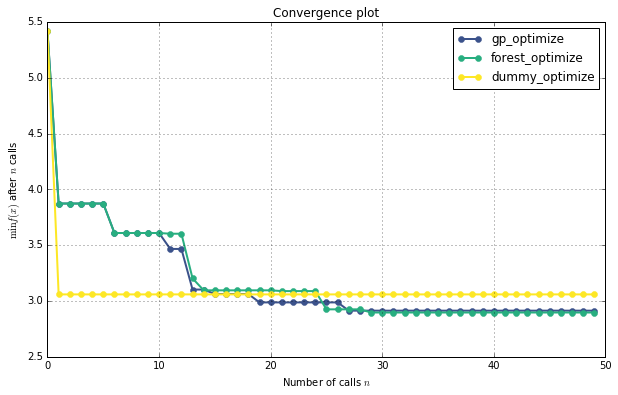

In [13]:
from skopt.plots import plot_convergence
plot_convergence(("gp_optimize", res_gp),
                 ("forest_optimize", res_forest),
                 ("dummy_optimize", res_dummy))

## Tuning a scikit-learn pipeline with `skopt`

Katie Malone, July 2016

### Introduction

Scikit-learn objects (transformers, estimators) are often not used singly, but instead chained together into a <a href="http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html">pipeline</a>.  When that happens, there can be several different sets of hyperparameters to examine, one for each object.  In the same way that `GridSearchCV` can be applied to a pipeline to tune the hyperparameters of several objects at once, we can do a more efficient search (this example uses GPs) over more than one scikit-learn object.  

In this example, we expand upon the optimization in <a href="hyperparameter-optimization.ipynb">this notebook</a>--that example optimizes over the parameters of a single object, a classifier, but now we'll simultaneously optimize over the parameters of a PCA transformation and a decision tree classifier.

In [14]:
import numpy as np
import sklearn.datasets
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

digits = sklearn.datasets.load_digits()
X = digits.data
y = digits.target

pca = PCA()
clf = DecisionTreeClassifier(random_state=42)
pipe = Pipeline([('pca', pca), ('clf', clf)])

### Defining the search space

Our parameter space has dimensions for the n_components parameter of PCA, as well as several parameters of the decision tree.
Optionally, we can also define a starting point for the search.

In [15]:
space  = [(2,20),  # n_components of PCA
          (1, 5),  # max_depth of tree
          (2, 30), # min_samples_split of tree
          (1, 30)] # min_samples_leaf of tree

x0 = [5, 3, 2, 1]  # optional starting point

In [16]:
from sklearn.cross_validation import cross_val_score
def objective(params):
    n_components, max_depth, min_samples_split, min_samples_leaf = params
    
    # set PCA n_components parameter
    pipe.set_params(pca__n_components=n_components)

    # set decision tree classifier parameters
    pipe.set_params(clf__max_depth=max_depth,
                   clf__max_features=n_components,
                   clf__min_samples_split=min_samples_split,
                   clf__min_samples_leaf=min_samples_leaf)

    error = -np.mean(cross_val_score(pipe, X, y, cv=5, n_jobs=-1, scoring="mean_absolute_error"))
    return error

/Users/civisemployee/src/scikit-optimize/src/sklearn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Optimize all the things!

In [17]:
from skopt import gp_minimize
import warnings
warnings.filterwarnings("ignore") # this minimize call issues a lot of warnings--quiet them
                                  # associated scikit-learn issue #6746

res_gp = gp_minimize(objective, space, x0=x0, n_calls=50, random_state=0)
print("Best score=%.4f" % res_gp.fun)
print("""Best parameters:
    - n_components=%d
    - max_depth=%d
    - min_samples_split=%d
    - min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1],
                                res_gp.x[2], res_gp.x[3]))

Best score=1.3882
Best parameters:
    - n_components=3
    - max_depth=5
    - min_samples_split=30
    - min_samples_leaf=30


We've started with a gaussian process algorithm; now add dummy and forest minimization functions to get a survey of the field.

In [18]:
from skopt import dummy_minimize
res_dummy = dummy_minimize(objective, space, x0=x0, n_calls=50, random_state=0)

from skopt import forest_minimize
res_forest = forest_minimize(objective, space, x0=x0, n_calls=50, random_state=0)

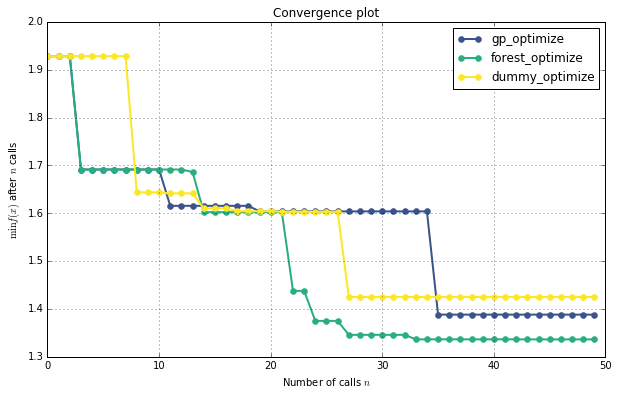

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)

from skopt.plots import plot_convergence
plot_convergence(("gp_optimize", res_gp),
                 ("forest_optimize", res_forest),
                 ("dummy_optimize", res_dummy))